# Bias–Variance Trade-off

For a quantitative response $y$ and $p$ predictors $X_1, X_2, \dots, X_p$, assume the relationship between $y$ and $X$ in the form
$$ y = f(X) + \epsilon ,$$
with $E[\epsilon] = 0$ and $Var(\epsilon) = \sigma^2$.

For a given estimate $\hat{f}$, which yields $\hat{y} = \hat{f}(X)$,
$$
\begin{align} 
    E[y - \hat{y}] & = E\left[ f\!\left(X\right) + \epsilon - \hat{f}\!\left(X\right) \right]^2 \\
                   & = E\left[ f\!\left(X\right) + \hat{f}\!\left(X\right) \right] ^2 + Var[\epsilon],
\end{align}
$$
where the term $E[ f(X) + \hat{f}(X) ] ^2$ is the **reducible error** and $Var(\epsilon)$ is the **irreducible error**.

The Mean Squared Error (MSE) for $n$ observations is
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{f}\!\left(x_i\right) \right)^2.
$$

The expected test MSE for a given value $x_0$ can always be decomposed into a sum of three fundamental quantiles:
- the variance of $\hat{f}(x_0)$,
- the squared bias of $\hat{f}(x_0)$, and
- the variance of the irreducible error term $\epsilon$.

That is,
$$
E\left[y_0 - \hat{f}\!\left(x_0\right)\right]^2 = Var\!\left[\hat{f}\!\left(x_0\right)\right] +
    Bias\!\left[ \hat{f}\!\left( x_0 \right) \right] ^ 2 + Var[\epsilon],
$$
where the bias of an estimate is 
$$
    Bias\!\left[ \hat{f}\!\left( x_0 \right) \right] = E\!\left[ \hat{f}\!\left( x_0 \right) \right] -
                f( x_0).
$$
We now have the MSE decomposed into reducible and irreducible error, which the former can be further separated into **bias** and **variance**. We wish to get a *low bias* and *low variance* estimator, without capturing the irreducible error.

**Variance** refers to the amount by which $\hat{f}(x)$ changes when estimated using a different training set.  **Bias** refers to the error introduced by the approximating the real function $f$ — for example, using a linear model $\hat{y} = \hat{f}(X)$ to approximate a non-linear relationship between $y$ and $X$.

## Data simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
%matplotlib inline

The real $f$ is unobserved, meaning we cannot explicitly compute the test MSE, bias, variance for a statistical learning method. However, we can illustrate the decomposition with artificial datasets.
Suppose we want to approximate the real function $f(X) = X^2$ with some irreducible error $\epsilon \sim N(\mu = 0, \sigma^2 = 0.07)$,
$$
    y = X^2 + \epsilon:
$$

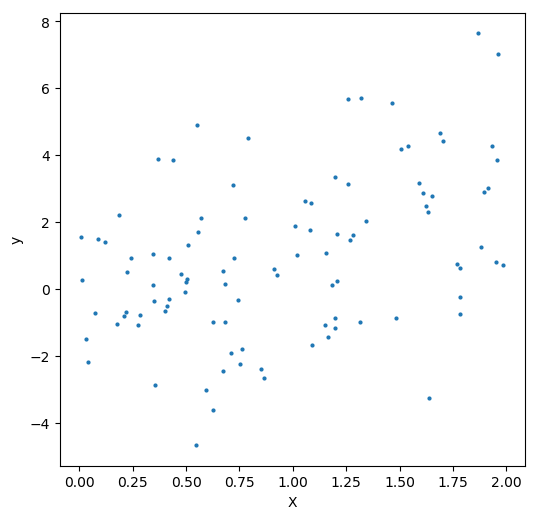

In [2]:
IRREDUCIBLE_VAR = 4

def f(x):
    return x ** 2

# Generate a dataset with some irreducible error
def sample_dataset(n_points=100, noise_mean=0, noise_var=IRREDUCIBLE_VAR, random_state=None):
    if random_state:
        np.random.seed(random_state)
    x = np.random.rand(n_points) * 2
    epsilon = np.random.normal(noise_mean, np.sqrt(noise_var), n_points)
    return x.reshape(-1, 1), f(x) + epsilon

X, y = sample_dataset(random_state=100)
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(X, y, s=4), plt.xlabel('X'), plt.ylabel('y');

Let us fit four models with different flexibilities.

In [3]:
poly = lambda degree: PolynomialFeatures(degree=degree, include_bias=True)

fit0 = make_pipeline(poly(0), LinearRegression()).fit(X, y)
fit1 = make_pipeline(poly(1), LinearRegression()).fit(X, y)
fit2 = make_pipeline(poly(2), LinearRegression()).fit(X, y)
fit3 = make_pipeline(poly(20), LinearRegression()).fit(X, y)

Using a new test dataset, we will plot its points, the real $y$ and the four models.

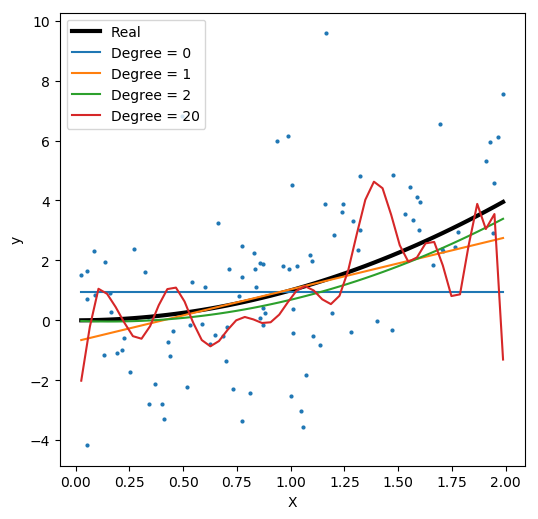

In [4]:
X_test, y_test = sample_dataset(random_state=2)
x = np.linspace(np.min(X_test), np.max(X_test), 50).reshape(-1, 1)
plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(X_test, y_test, s=4), plt.xlabel('X'), plt.ylabel('y');
plt.plot(x, f(x), label='Real', c='black', lw=3)
plt.plot(x, fit0.predict(x), label='Degree = 0')
plt.plot(x, fit1.predict(x), label='Degree = 1')
plt.plot(x, fit2.predict(x), label='Degree = 2')
plt.plot(x, fit3.predict(x), label='Degree = 20')
plt.legend();

Since we know the actual $f$ and the irreducible error, we can estimate the bias and the variance of each model. Fix a $x_0$, such as $0.95$ and estimate its $y$.

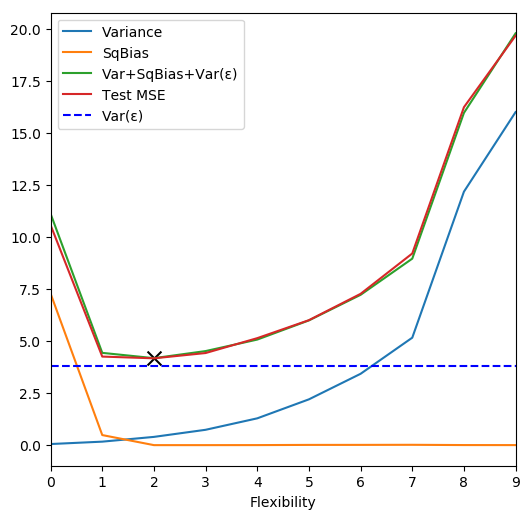

In [5]:
def decompose_mse(make_estimator, make_dataset, real_function, x0, irreducible_var=0.3, 
                  flexibilities=10, trials=1000):
    """
    Given a known real function, decompose the MSE into variance, bias and irreducible error.
    We estimate this with a fixed |x0|.
    For a known function y = f(x) + ε
        |make_estimator|: a function make_estimator(flexibility) that builds an estimator for
                          a given flexibility.
        |real_function|: the known f(x).
        |irreducible_var|: the irreducible error variance,
                           ε ~ N(μ = 0, σ² = |irreducible_var|).
        |flexibilities|: the maximum flexibility to test. This is varied from 0 to
                         |flexibilities|, calling |make_estimator|.
        |trials|: number of calls to |make_dataset| for each model’s flexibility.
    """
    epsilon = np.random.normal(0, np.sqrt(irreducible_var), trials)
    y0 = real_function(x0) + epsilon
    results = list()
    for flexibility in range(flexibilities):
        model = make_estimator(flexibility) 
        predicted = list()
        for trial in range(trials):
            X, y = make_dataset(random_state=trial)
            model.fit(X, y)
            predicted.append(model.predict(x0))
        predicted = np.concatenate(predicted)

        mse = np.mean((predicted - y0) ** 2)
        var = np.var(predicted)
        bias = np.mean(predicted) - real_function(x0)

        results.append(pd.DataFrame({
            'Variance': var,
            'SqBias': bias ** 2,
            'Var+SqBias+Var(ε)': var + bias ** 2 + np.var(epsilon),
            'Test MSE': mse
        }, index=[flexibility]))
    cols = ['Variance', 'SqBias', 'Var+SqBias+Var(ε)', 'Test MSE']
    return pd.concat(results)[cols], np.var(epsilon)

def polynomial_lr(flexibility):
    return make_pipeline(poly(flexibility), LinearRegression())

results, eps_var = decompose_mse(
    make_estimator=polynomial_lr,
    make_dataset=sample_dataset,
    real_function=f,
    x0=2.01,
    irreducible_var=IRREDUCIBLE_VAR,
    flexibilities=10, 
    trials=1000)
    
plt.figure(figsize=(6, 6), dpi=100)
x = np.linspace(0, results.shape[0], 50).reshape(-1, 1)
results.plot(ax=plt.gca())
plt.plot(x, np.repeat(eps_var, 50), ls='--', c='b', label='Var(ε)')
plt.scatter(np.argmin(results['Test MSE']), np.min(results['Test MSE']),
           marker='x', s=100, c='black')
plt.legend()
plt.xlabel('Flexibility')
plt.show()

For each model flexibility (the degree of polynomial features), we computed the MSE and its decomposition. The dashed line in the minimum possible error for the dataset — the irreducible error.

As the model’s flexibility increases, the bias decreases, while the variable increases. The Test MSE shows a U-shape, as expected. The ideal model is the one with flexibility 2 (marked with an X), which is the closest to our real function $f(x) = x^2$. Let’s inspect the how close is  the `Test MSE` with the approximated `Var+SqBias+Var(ε)`:

In [6]:
results

,Variance,SqBias,Var+SqBias+Var(ε),Test MSE
0,0.052557,7.280965e+00,11.116165,10.572753
1,0.167430,4.836826e-01,4.433755,4.255188
2,0.395963,1.781997e-05,4.178624,4.171611
3,0.737090,1.658053e-07,4.519733,4.425674
4,1.287714,1.701260e-03,5.072058,5.140675
5,2.200439,1.077196e-02,5.993854,6.004528
6,3.428068,1.179708e-02,7.222508,7.270021
7,5.163016,1.559730e-02,8.961256,9.209151
8,12.179060,3.226633e-03,15.964930,16.237962
9,16.004453,1.639013e-03,19.788735,19.674378


### References

This text was adapted from two sources:

**David Dalpiaz (2017)** R for statistical learning. https://daviddalpiaz.github.io/r4sl/simulating-the-biasvariance-tradeoff.html

**Gareth James, Daniela Witten, Trevor Hastie & Robert Tibshirani (2014)** An Introduction to Statistical Learning: With Applications in R. Springer Publishing Company, Incorporated. http://www.springer.com/us/book/9781461471370